In [8]:
!pip install --upgrade "cuda-python>=12.6.2"
!pip install opencv-python kagglehub kaggle numpy torch torchvision facenet_pytorch matplotlib seaborn torchinfo pylibraft-cu12==25.2.* rmm-cu12==25.2.* --no-deps

In [9]:
import os
import csv
import math
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import roc_curve
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization

In [10]:
data_dir = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
pairs_path = '/kaggle/input/lfw-dataset/pairs.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')
np.random.seed(5)

Running on device: cuda


In [11]:
def read_pairs(pairs_filename):
    """Read pairs from CSV file"""
    pairs = []
    with open(pairs_filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            pairs.append(row)
    return np.array(pairs, dtype=object)

In [12]:
def get_paths(lfw_dir, pairs):
    """Get paths for image pairs and whether they're the same person"""
    path1_list = []
    path2_list = []
    issame_list = []
    nrof_skipped_pairs = 0
    for pair in pairs:
        name1 = pair[0]
        idx1 = int(pair[1])
        
        if pair[2].isdigit():
            idx2 = int(pair[2])
            name2 = name1
            issame = True
        else:
            name2 = pair[2]
            idx2 = int(pair[3])
            issame = False

        path1 = f"{lfw_dir}/{name1}/{name1}_{idx1:04d}.jpg"
        path2 = f"{lfw_dir}/{name2}/{name2}_{idx2:04d}.jpg"

        if os.path.exists(path1) and os.path.exists(path2):
            path1_list.append(path1)
            path2_list.append(path2)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1

    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    return path1_list, path2_list, issame_list

In [13]:
pairs = read_pairs(pairs_path)
path1_list, path2_list, issame_list = get_paths(data_dir, pairs)
print(len(path1_list))
print(len(path2_list))
print(len(issame_list))

6000
6000
6000


In [14]:
mtcnn = MTCNN(
    image_size=160,
    margin=14,
    device=device,
    selection_method='center_weighted_size'
)

In [15]:
resnet = InceptionResnetV1(classify=False, pretrained='vggface2').to(device).eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_file)

In [16]:
def get_face_embeddings(image_paths):
    embeddings = []
    with torch.no_grad():
        for img_path in image_paths:
            try:
                img = Image.open(img_path)
                face = mtcnn(img)
                if face is not None:
                    face = face.to(device)
                    embedding = resnet(face.unsqueeze(0))
                    embeddings.append(embedding.cpu().numpy()[0])
                else:
                    print(f"No face detected in {img_path}")
                    embeddings.append(np.random.rand(512))
                    
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                embeddings.append(np.random.rand(512))
    return embeddings

In [17]:
embeddings1 = get_face_embeddings(path1_list)

No face detected in /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Marilyn_Monroe/Marilyn_Monroe_0001.jpg


In [18]:
embeddings2 = get_face_embeddings(path2_list)

In [20]:
embeddings1 = np.array([np.random.rand(512) if e is None else e for e in embeddings1])
embeddings2 = np.array([np.random.rand(512) if e is None else e for e in embeddings2])
actual_issame = np.asarray(issame_list, dtype=bool)

In [29]:
print(len(embeddings1))
print(len(embeddings2))
print(len(actual_issame))

6000
6000
6000


In [21]:
torch.cuda.empty_cache()

In [22]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:       # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:     # Cosine similarity
        dots = np.sum(embeddings1 * embeddings2, axis=1)
        norms = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        dist = np.clip(1 - (dots / norms), 0, 2)
    else:
        raise 'Undefined distance metric %d' % distance_metric
    return dist

In [23]:
def evaluate_with_visualization(embeddings1, embeddings2, actual_issame):
    distances = distance(embeddings1, embeddings2, distance_metric=1)
    
    # ROC analysis
    fpr, tpr, thresholds = roc_curve(actual_issame, -distances)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = -thresholds[optimal_idx]
    
    # Calculate metrics
    pred_issame = distances <= optimal_threshold
    tp = np.sum(pred_issame & actual_issame)
    fp = np.sum(pred_issame & ~actual_issame)
    tn = np.sum(~pred_issame & ~actual_issame)
    fn = np.sum(~pred_issame & actual_issame)
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # 1. Distance Distribution
    plt.subplot(131)
    plt.hist(distances[actual_issame], bins=50, alpha=0.5, 
             label=f'Genuine (μ={np.mean(distances[actual_issame]):.2f})')
    plt.hist(distances[~actual_issame], bins=50, alpha=0.5, 
             label=f'Impostor (μ={np.mean(distances[~actual_issame]):.2f})')
    plt.axvline(optimal_threshold, color='r', linestyle='--', 
                label=f'Threshold={optimal_threshold:.2f}')
    plt.xlabel('Cosine Distance (0=identical)')
    plt.ylabel('Count')
    plt.legend()
    
    # 2. ROC Curve
    plt.subplot(132)
    plt.plot(fpr, tpr, label=f'AUC={np.trapz(tpr, fpr):.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], c='r', 
                label=f'Optimal (FPR={fpr[optimal_idx]:.3f}, TPR={tpr[optimal_idx]:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # 3. Threshold Analysis
    plt.subplot(133)
    plt.plot(-thresholds, tpr, label='TPR')
    plt.plot(-thresholds, fpr, label='FPR')
    plt.axvline(optimal_threshold, color='r', linestyle='--')
    plt.xlabel('Threshold (Distance)')
    plt.ylabel('Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics
    metrics = {
        'accuracy': (tp + tn) / len(actual_issame),
        'tpr': tp / (tp + fn + 1e-8),
        'fpr': fp / (fp + tn + 1e-8),
        'threshold': optimal_threshold,
        'auc': np.trapz(tpr, fpr),
        'distance_stats': {
            'genuine_mean': np.mean(distances[actual_issame]),
            'impostor_mean': np.mean(distances[~actual_issame]),
            'min': np.min(distances),
            'max': np.max(distances)
        }
    }
    
    # Print metrics in a readable format
    print("\nVerification Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.2%}")
    print(f"True Positive Rate: {metrics['tpr']:.2%}")
    print(f"False Positive Rate: {metrics['fpr']:.2%}")
    print(f"Optimal Threshold: {metrics['threshold']:.4f}")
    print(f"AUC: {metrics['auc']:.3f}")
    print("\nDistance Statistics:")
    print(f"Genuine mean: {metrics['distance_stats']['genuine_mean']:.4f}")
    print(f"Impostor mean: {metrics['distance_stats']['impostor_mean']:.4f}")
    print(f"Minimum distance: {metrics['distance_stats']['min']:.4f}")
    print(f"Maximum distance: {metrics['distance_stats']['max']:.4f}")
    
    return metrics

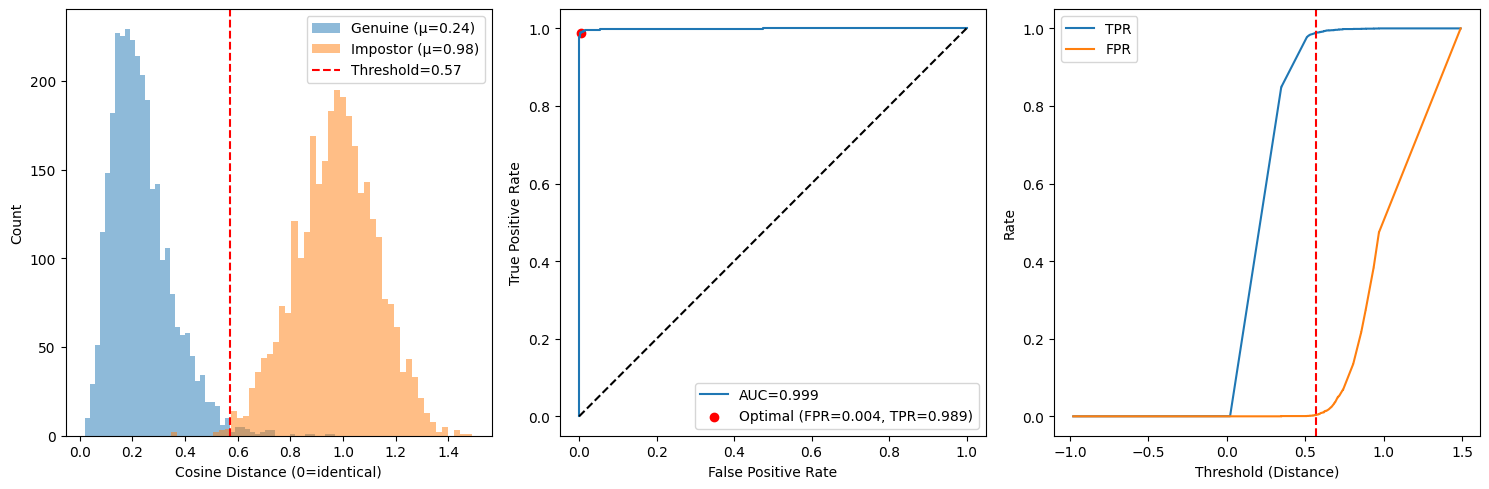


Verification Metrics:
Accuracy: 99.28%
True Positive Rate: 98.93%
False Positive Rate: 0.37%
Optimal Threshold: 0.5698
AUC: 0.999

Distance Statistics:
Genuine mean: 0.2352
Impostor mean: 0.9751
Minimum distance: 0.0206
Maximum distance: 1.4909


In [26]:
result = evaluate_with_visualization(embeddings1, embeddings2, actual_issame)

In [25]:
def compare_faces(img_path1, img_path2, threshold=0.7):
    result = {
        'match': False,
        'similarity': 0.0,
        'message': "Initialization",
        'error': None
    }
    
    try:
        try:
            img1 = Image.open(img_path1).convert('RGB')
            img2 = Image.open(img_path2).convert('RGB')
        except Exception as e:
            result.update({
                'message': "Couldn't load images",
                'error': f"Image loading failed: {str(e)}"
            })
            return result

        try:
            face1 = mtcnn(img1)
            face2 = mtcnn(img2)
        except Exception as e:
            result.update({
                'message': "Face detection error",
                'error': f"Detection failed: {str(e)}"
            })
            return result

        if face1 is None or face2 is None:
            result.update({
                'message': "Couldn't detect face in one or both images",
                'error': "Face detection returned None"
            })
            return result

        try:
            embedding1 = resnet(face1.unsqueeze(0).to(device)).detach().cpu().numpy()
            embedding2 = resnet(face2.unsqueeze(0).to(device)).detach().cpu().numpy()
        except Exception as e:
            result.update({
                'message': "Embedding generation failed",
                'error': f"Embedding error: {str(e)}"
            })
            return result

        try:
            similarity = np.dot(embedding1, embedding2.T) / (
                np.linalg.norm(embedding1) * np.linalg.norm(embedding2) + 1e-10  # Avoid division by zero
            )
            similarity = float(similarity[0][0])
        except Exception as e:
            result.update({
                'message': "Similarity calculation failed",
                'error': f"Math error: {str(e)}"
            })
            return result

        is_match = similarity >= threshold
        
        result.update({
            'match': is_match,
            'similarity': similarity,
            'message': "Same person" if is_match else "Different people",
            'error': None
        })
        
    except Exception as e:
        result.update({
            'message': "Unexpected comparison failure",
            'error': f"System error: {str(e)}"
        })
    
    return result
result = compare_faces("/kaggle/input/testimg/s1.jpg", "/kaggle/input/testimg/s3.jpg")
print(f"Result: {result['message']} (Similarity: {result['similarity']:.2%})")

Result: Same person (Similarity: 77.98%)


In [30]:
def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False):
    actual_issame = np.asarray(actual_issame, dtype=bool)
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    is_false_positive = []
    is_false_negative = []

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx], _ ,_ = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _, _, _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
        _, _, accuracy[fold_idx], is_fp, is_fn = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
        is_false_positive.extend(is_fp)
        is_false_negative.extend(is_fn)

    return tpr, fpr, accuracy, is_false_positive, is_false_negative

In [31]:
def calculate_accuracy(threshold, dist, actual_issame):
    assert np.isscalar(threshold), "threshold must be a scalar"
    assert len(dist) == len(actual_issame), "dist and actual_issame must match in length"
    actual_issame = np.asarray(actual_issame, dtype=bool)  # Force bool
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    is_fp = np.logical_and(predict_issame, np.logical_not(actual_issame))
    is_fn = np.logical_and(np.logical_not(predict_issame), actual_issame)

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc, is_fp, is_fn

In [37]:
def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])

        if np.max(far_train) >= far_target:
            # Remove duplicates while preserving order
            unique_far, unique_idx = np.unique(far_train, return_index=True)
            unique_thresholds = thresholds[unique_idx]
            
            if len(unique_far) >= 2:
                f = interpolate.interp1d(unique_far, unique_thresholds, kind='slinear')
                threshold = f(far_target)
            else:
                threshold = thresholds[-1]
        else:
            threshold = thresholds[-1]

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean

In [33]:
def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = 0.0 if n_same == 0 else float(true_accept)/float(n_same)
    far = 0.0 if n_diff == 0 else float(false_accept)/float(n_diff)
    return val, far

In [34]:
def evaluate(embeddings1, embeddings2, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    tpr, fpr, accuracy, fp, fn  = calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    return tpr, fpr, accuracy, val, val_std, far, fp, fn

In [63]:
from sklearn.model_selection import KFold
from scipy import interpolate
import numpy as np
tpr, fpr, accuracy, val, val_std, far, fp, fn = evaluate(embeddings1, embeddings2, actual_issame, distance_metric=1, subtract_mean=True)

In [64]:
accuracy

array([1.        , 0.99666667, 0.99      , 0.99      , 0.98333333,
       0.99666667, 0.98833333, 0.995     , 0.99666667, 0.99666667])

In [65]:
np.mean(accuracy)

0.9933333333333332